In [26]:
# Core imports
import os

# Third party imports
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.ops import unary_union


# Module importss
from modules import (dl_csv_make_df, find_points_in_poly, geo_df_from_csv,
                     geo_df_from_geospatialfile)

# TODO: inventory check: why is get_and_save_geo_dataset not used

# get current working directory
cwd = os.getcwd()

# define data directory
data_dir = (os.path.join
            (cwd,
             'data'))

# define some params related to zip download
zip_link = "http://naptan.app.dft.gov.uk/DataRequest/Naptan.ashx?format=csv"
zip_name = "Napatan.zip"
zip_path = os.path.join(data_dir, zip_name)
csv_nm = 'Stops.csv'
csv_path = os.path.join(data_dir, csv_nm)

# Download the zip file and extract the stops csv
_ = dl_csv_make_df(csv_nm,
                   csv_path,
                   zip_name,
                   zip_path,
                   zip_link,
                   data_dir)

# Create the geo dataframe with the stops data
cols = ['NaptanCode', 'CommonName', 'Easting', 'Northing']

stops_geo_df = (geo_df_from_csv(path_to_csv=csv_path,
                                delim=',',
                                geom_x='Easting',
                                geom_y='Northing',
                                cols=cols))

# # Getting the Lower Super Output Area for the UK into a dataframe
uk_LSOA_shp_file = "Lower_Layer_Super_Output_Areas__December_2011__Boundaries_EW_BGC.shp"
full_path = os.path.join(os.getcwd(), "data", "LSOA_shp", uk_LSOA_shp_file)
uk_LSOA_df = geo_df_from_geospatialfile(path_to_file=full_path)


def get_polygons_of_loccode(geo_df, dissolveby='OA11CD', search=None):
    """
    Gets the polygon for a place based on it name, LSOA code or OA code

    Parameters:
    geo_df: (gpd.Datafame):
    loc_code = LSOA11CD, OA11CD or LSOA11NM
    search = search terms to find in the LSOA11NM column. Only needed if
        intending to dissolve on a name in the LSOA11NM column
    Returns: (gpd.DataFrame) agregated multipolygons, agregated on LSOA,
        OA code, or a search in the LSOA11NM column
    """
    if dissolveby in ['LSOA11CD', 'OA11CD']:
        polygon_df = geo_df.dissolve(by=dissolveby)
    else:
        filtered_df = geo_df[geo_df[f'{dissolveby}'].str.contains(search)]
        filtered_df.insert(0, 'place_name', search)
        polygon_df = filtered_df.dissolve(by='place_name')
    polygon_df = gpd.GeoDataFrame(polygon_df.pop('geometry'))
    return polygon_df


just_birmingham_poly = (get_polygons_of_loccode(
    geo_df=uk_LSOA_df, dissolveby='LSOA11NM', search="Birmingham"))


# Creating Birmingham polygon

# just_birmingham_geom = just_birmingham_LSOA.drop(["FID","LSOA11CD","LSOA11NMW","Age_Indica", "Shape__Are","Shape__Len","LSOA11NM"], axis=1)
# # just_birmingham_geom = just_birmingham_LSOA.pop('geometry')

# just_birmingham_geom['city'] = "birmingham"
# # just_birmingham_geom['new_column'] = 0
# just_birmingham_geom = just_birmingham_geom.dissolve(by='city')
# just_birmingham_geom


# Creating a Geo Dataframe of only stops in Birmingham
# import ipdb; ipdb.set_trace()
birmingham_stops_geo_df = (find_points_in_poly
                           (geo_df=stops_geo_df,
                            polygon_obj=just_birmingham_poly))




csv already exists


In [27]:
# Getting the west midlands population
Wmids_pop_df = pd.read_csv(os.path.join
                           (data_dir,
                            'population_estimates',
                            'westmids_pop_only.csv'))


/home/james/anaconda3/envs/SDG_11.2.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
# Get population weighted centroids into a dataframe
uk_pop_wtd_centr_df = (geo_df_from_geospatialfile
                       (os.path.join
                        (data_dir,
                         'pop_weighted_centroids')))

In [29]:
# Understanding was the OA11CD codes look like by taking a sample.
uk_pop_wtd_centr_df.sample(10)

# Joining the population dataframe to the centroids dataframe
Wmids_pop_df = Wmids_pop_df.join(
    other=uk_pop_wtd_centr_df.set_index('OA11CD'), on='OA11CD', how='left')


In [74]:
# TODO: check if this is needed
bham_LSOA_df = uk_LSOA_df[uk_LSOA_df.LSOA11NM.str.contains("Birmingham")]
bham_LSOA_df = bham_LSOA_df[['LSOA11CD', 'LSOA11NM','geometry']]

In [75]:
bham_LSOA_df

,LSOA11CD,LSOA11NM,geometry
7851,E01009100,Birmingham 025D,"POLYGON ((413200.676 292367.173, 413122.403 29..."
7853,E01009101,Birmingham 029D,"POLYGON ((413726.186 291332.427, 413845.008 29..."
7855,E01009102,Birmingham 028D,"POLYGON ((413534.794 291340.195, 413635.776 29..."
8652,E01008881,Birmingham 067A,"POLYGON ((412876.688 285871.549, 412942.142 28..."
8653,E01008882,Birmingham 066A,"POLYGON ((411667.683 285737.519, 411792.872 28..."
...,...,...,...
32721,E01033646,Birmingham 031I,"POLYGON ((410609.627 291772.410, 410553.336 29..."
32722,E01033647,Birmingham 058E,"POLYGON ((410240.798 287278.706, 410275.917 28..."
32723,E01033648,Birmingham 084F,"POLYGON ((407764.808 284162.726, 408102.309 28..."
32724,E01033649,Birmingham 058F,"POLYGON ((410569.039 287316.619, 410610.171 28..."


In [79]:
# merge the two dataframes limiting to just Birmingham
bham_pop_df = Wmids_pop_df.merge(bham_LSOA_df,
                                 how='right',
                                 left_on='LSOA11CD',
                                 right_on='LSOA11CD',
                                 suffixes=('_pop', '_LSOA'))

In [80]:
bham_pop_df.head()

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,85,86,87,88,89,90+,OBJECTID,geometry_pop,LSOA11NM,geometry_LSOA
0,E00046134,E01009100,320,1,4,4,1,3,5,2,...,2,1,1,2,1,5,133250,POINT (412618.625 291362.529),Birmingham 025D,"POLYGON ((413200.676 292367.173, 413122.403 29..."
1,E00046136,E01009100,358,4,4,2,6,7,8,5,...,0,4,0,1,2,4,133246,POINT (412705.789 291126.947),Birmingham 025D,"POLYGON ((413200.676 292367.173, 413122.403 29..."
2,E00046145,E01009100,201,1,1,2,3,1,4,1,...,0,1,0,0,0,2,131136,POINT (412594.979 292012.980),Birmingham 025D,"POLYGON ((413200.676 292367.173, 413122.403 29..."
3,E00046184,E01009100,335,7,1,3,5,6,3,2,...,4,2,3,3,2,14,132183,POINT (412710.933 292168.295),Birmingham 025D,"POLYGON ((413200.676 292367.173, 413122.403 29..."
4,E00175609,E01009100,244,5,3,4,1,6,5,6,...,0,1,1,0,0,2,133854,POINT (412670.918 291843.864),Birmingham 025D,"POLYGON ((413200.676 292367.173, 413122.403 29..."


In [32]:
# rename the All Ages column
bham_pop_df.rename(columns={"All Ages":"pop_count"}, inplace=True)

In [33]:
# change pop_count to number (int)
bham_pop_df['pop_count'] = pd.to_numeric(bham_pop_df.pop_count.str.replace(",", ""))

In [34]:
def buffer_points(geo_df, distance_km=500):
    """
    Provide a Geo Dataframe with points you want buffering.
    Draws a 5km (radius) buffer around the points.
    Puts the results into a new column called "buffered"
    As 'epsg:27700' projections units of km, 500m is 0.5km.
    """
    geo_df['geometry'] = geo_df.geometry.buffer(distance_km)
    return geo_df


In [35]:
_ = buffer_points(birmingham_stops_geo_df)

In [36]:
# TODO: try to join all the birmingham buffered stops together
# to get the service area, then plot them

bham_stops_geo_df = birmingham_stops_geo_df


In [37]:
# grab some coordinates for a little section of birmingham
ag_east_north = pd.read_csv('Acocks_Green_postcodes.csv', usecols=['Easting', 'Northing'])

eastings = [easting for easting in ag_east_north.Easting]
northings = [northing for northing in ag_east_north.Northing]
east_min = min(eastings)
east_max = max(eastings)
north_min = min(northings)
north_max = max(northings)

In [44]:
# limit the stops, filtering by the min/max eastings/northings for Acocks Green
north_mask = (north_min < birmingham_stops_geo_df['Northing']) & (birmingham_stops_geo_df['Northing'] < north_max)
east_mask = (east_min < birmingham_stops_geo_df['Easting']) & (birmingham_stops_geo_df['Easting'] < east_max)
# Filter the stops 
ag_stops_geo_df = birmingham_stops_geo_df[north_mask & east_mask]

In [45]:
ag_stops_poly = unary_union(list(ag_stops_geo_df.geometry))

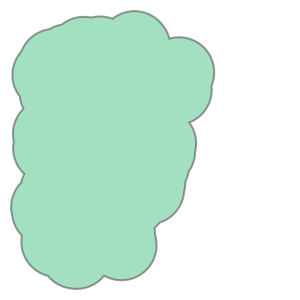

In [46]:
ag_stops_poly

In [48]:
bham_stops_poly = unary_union(list(birmingham_stops_geo_df.geometry))

In [315]:
bham_stops_geo_df['diss'] = 'Birmingham'
bham_buffd_stops = bham_stops_geo_df.dissolve(by='diss')['geometry']

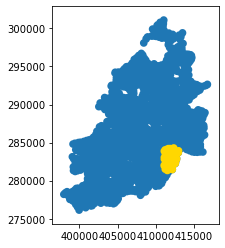

In [68]:
# Get all the buffered stops in Birmingham on to a map of Birmingham
fig, ax = plt.subplots()
p = gpd.GeoSeries(bham_stops_poly)
# Plot Acocks Green only stops
a = gpd.GeoSeries(ag_stops_poly)
p.plot(ax=ax)
a.plot(ax=ax, color='gold')
plt.show()
fig.savefig('bham_ag_stops.png') 

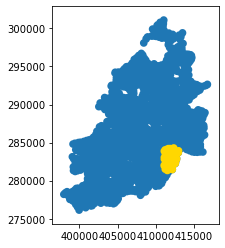

In [67]:
fig

In [22]:
bham_pop_df['pop_count'].sum()

1141816

In [47]:
birmingham_stops_geo_df.head()

,NaptanCode,CommonName,Easting,Northing,geometry,place
133809,wocdjdam,Groveley Lane- Chestnut Drive,400503,275966,"POLYGON ((400503.500 275966.000, 400503.498 27...",Birmingham
133932,wocdgwmt,Grovely Corner-,403083,277083,"POLYGON ((403083.500 277083.000, 403083.498 27...",Birmingham
135404,wocdtmdw,Edenhurst Road,401532,276681,"POLYGON ((401532.500 276681.000, 401532.498 27...",Birmingham
136947,wocgmpwt,Longbridge- Groveley Lane- Coombs Lane,401662,276707,"POLYGON ((401662.500 276707.000, 401662.498 27...",Birmingham
136948,wocgmtad,Longbridge- Groveley Lane- Coombs Lane,401689,276794,"POLYGON ((401689.500 276794.000, 401689.498 27...",Birmingham


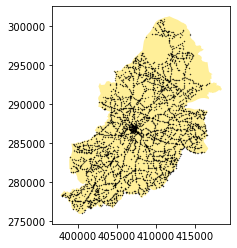

In [45]:
fig, ax = plt.subplots()
_ = just_birmingham_poly.plot(ax=ax, color='gold', alpha=0.4)
_ = birmingham_stops_geo_df.plot(ax=ax, color='black', markersize=0.1, alpha=0.8)


In [48]:
birmingham_stops_geo_df.head()

,NaptanCode,CommonName,Easting,Northing,geometry,place
133809,wocdjdam,Groveley Lane- Chestnut Drive,400503,275966,"POLYGON ((400503.500 275966.000, 400503.498 27...",Birmingham
133932,wocdgwmt,Grovely Corner-,403083,277083,"POLYGON ((403083.500 277083.000, 403083.498 27...",Birmingham
135404,wocdtmdw,Edenhurst Road,401532,276681,"POLYGON ((401532.500 276681.000, 401532.498 27...",Birmingham
136947,wocgmpwt,Longbridge- Groveley Lane- Coombs Lane,401662,276707,"POLYGON ((401662.500 276707.000, 401662.498 27...",Birmingham
136948,wocgmtad,Longbridge- Groveley Lane- Coombs Lane,401689,276794,"POLYGON ((401689.500 276794.000, 401689.498 27...",Birmingham


In [49]:
stops_geo_df.head()

,NaptanCode,CommonName,Easting,Northing,geometry
0,bstdpgj,Bedminster Road,359265,173143,POINT (359265.000 173143.000)
1,bstjdam,Henry St Green Street,359264,173142,POINT (359264.000 173142.000)
2,bstdjaj,Ilchester Crescent,359256,173152,POINT (359256.000 173152.000)
3,bstdjdp,Ilchester Crescent,359258,173145,POINT (359258.000 173145.000)
4,bstatmd,Swiss Road,359269,173135,POINT (359269.000 173135.000)


In [50]:
just_birmingham_poly

,geometry
place_name,
Birmingham,"POLYGON ((405940.897 278844.452, 405969.012 27..."


In [51]:
birmingham_stops_geo_df = (find_points_in_poly
                           (geo_df=stops_geo_df,
                            polygon_obj=just_birmingham_poly))

In [52]:
stops_geo_df.head()

,NaptanCode,CommonName,Easting,Northing,geometry
0,bstdpgj,Bedminster Road,359265,173143,POINT (359265.000 173143.000)
1,bstjdam,Henry St Green Street,359264,173142,POINT (359264.000 173142.000)
2,bstdjaj,Ilchester Crescent,359256,173152,POINT (359256.000 173152.000)
3,bstdjdp,Ilchester Crescent,359258,173145,POINT (359258.000 173145.000)
4,bstatmd,Swiss Road,359269,173135,POINT (359269.000 173135.000)


In [53]:
just_birmingham_poly

,geometry
place_name,
Birmingham,"POLYGON ((405940.897 278844.452, 405969.012 27..."


In [61]:
birmingham_stops_geo_df.head()

,NaptanCode,CommonName,Easting,Northing,geometry,place
133809,wocdjdam,Groveley Lane- Chestnut Drive,400503,275966,"POLYGON ((400504.499 275966.049, 400504.499 27...",Birmingham
133932,wocdgwmt,Grovely Corner-,403083,277083,"POLYGON ((403084.499 277083.049, 403084.499 27...",Birmingham
135404,wocdtmdw,Edenhurst Road,401532,276681,"POLYGON ((401533.499 276681.049, 401533.499 27...",Birmingham
136947,wocgmpwt,Longbridge- Groveley Lane- Coombs Lane,401662,276707,"POLYGON ((401663.499 276707.049, 401663.499 27...",Birmingham
136948,wocgmtad,Longbridge- Groveley Lane- Coombs Lane,401689,276794,"POLYGON ((401690.499 276794.049, 401690.499 27...",Birmingham
